# **Image Captioning (Using Flickr8k Dataset)**
## **MohammadMahdi Sadeghi - 610301149**

# **Importing Required Libraries**

In [28]:
import random
import os
import pandas as pd
import numpy as np
from PIL import Image
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
import re
import matplotlib.pyplot as plt


# **Data preprocessing**
### **process_captions**
This function reads an input captions file, processes each line to clean and format the captions, and writes the processed captions to an output file.
* Reads the input file line by line.
* Splits each line at the first comma to separate the image ID from the caption.
* Removes non-alphabetic characters from the caption except spaces.
* Adds "SOS" (start of sentence) and "EOS" (end of sentence) tokens to each caption.
* Writes the cleaned and formatted captions to the output file.

### **Flickr8kDataset**
This class is a custom dataset for handling images and their corresponding captions.

### **transform**
* Resizing: Ensures all images are of the same size, matching the model's input requirements.
* Converting to Tensor: Converts images to a format that PyTorch models can process.

### **Splitting Data**
Splitting Data into training and testing sets using scikit-learn's train_test_split function.

### **collate_fn**
This function ensures captions are padded to the same length for batching.

In [29]:
def process_captions(input_file, output_file):
    with open(input_file, 'r') as file:
        lines = file.readlines()
    
    with open(output_file, 'w') as file:
        for line in lines:
            # split the line at the comma
            parts = line.strip().split(',', 1)
            if len(parts) == 2:
                image_id, caption = parts
                # replace the comma with a tab
                formatted_line = f"{image_id}\t{caption}\n"
                # Remove non-alphabetic characters except spaces from the caption
                cleaned_caption = re.sub(r'[^a-zA-Z\s]', '', caption)
                # write the formatted and cleaned line to the output file
                file.write(f"{image_id}\t{"<SOS> " + cleaned_caption + " <EOS>"}\n")

# define input and output file paths
input_file = 'captions.txt'
output_file = 'newCaptions.txt'

# process the captions
process_captions(input_file, output_file)

DATA_DIR = 'Images'
CAPTIONS_FILE = 'newCaptions.txt'


# load captions file
captions = pd.read_csv(CAPTIONS_FILE, delimiter='\t', names=['image', 'caption'])

# creating vocab
# adding special tokens
vocab = {}
vocab['<PAD>'] = 0
vocab['<SOS>'] = 1
vocab['<EOS>'] = 2
vocab['<UNK>'] = 3 # for handling unknown words

idx = 4

for caption in captions['caption']:
    tokens = caption.lower().split()

    for word in tokens:
        if word not in vocab.keys():
            vocab[word] = idx
            idx += 1

vocab_size = len(vocab)


class Flickr8kDataset(Dataset):
    def __init__(self, captions, image_path, transform=None):
        self.captions = captions
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_path, self.captions.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # assuming column 1 contains the caption and it is tokenized properly
        caption = [vocab.get(word, vocab['<UNK>']) for word in self.captions.iloc[idx, 1].split()]
        caption = torch.tensor([vocab['<SOS>']] + caption + [vocab['<EOS>']])  # add SOS and EOS tokens
        return image, caption


transform = transforms.Compose([
    transforms.Resize((224, 224)), # resizing
    transforms.ToTensor() # converting to Tensor
])

# split data into training and testing
train_data, test_data = train_test_split(captions, test_size=0.2, random_state=42)
train_dataset = Flickr8kDataset(train_data, DATA_DIR, transform)
test_dataset = Flickr8kDataset(test_data, DATA_DIR, transform)

def collate_fn(batch):
    images, captions = zip(*batch)
    
    # stack images
    images = torch.stack(images, 0)
    
    # pad captions
    lengths = [len(cap) for cap in captions]
    padded_captions = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        padded_captions[i, :end] = cap[:end]
    
    return images, padded_captions

# create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# **Building Model**

## **1. CNN Model**
The CNN model uses a pre-trained ResNet-18 architecture to extract features from images. The features are then passed through a fully connected layer to produce a feature vector of a fixed size.

* ### **Initialization**

    * The pre-trained ResNet-18 model is loaded.
    * All layers except the last one are extracted ([:-1]), as the final fully connected layer of ResNet-18 is replaced.
    * A new fully connected layer is defined to output a 256-dimensional feature vector.
    * If freeze is True, all the layers of the ResNet-18 are frozen to prevent their weights from being updated during training.

* ### **Forward Function**

    * The input image is passed through the CNN layers.
    * The output is flattened and passed through the fully connected layer to obtain the feature vector.


## **2. LSTM Model**
The LSTM model generates captions based on the image features and the input captions.

* ### **Initialization**

    * An embedding layer converts word indices to dense vectors.
    * An LSTM layer processes sequences of concatenated image features and embedded captions.
    * A fully connected layer maps the LSTM output to the vocabulary size, providing word predictions.

* ### **Forward Function**

    * Captions are embedded into dense vectors.
    * Image features are expanded to match the sequence length of the captions and concatenated with the embedded captions.
    * The concatenated input is processed by the LSTM.
    * The LSTM output is passed through a fully connected layer to produce word predictions.

## **3. Combined Model**
The combined model integrates the CNN and LSTM models to form the complete image captioning architecture.
* ### **Initialization**

    * The CNN and LSTM models are instantiated and stored as attributes.

* ### **Forward Method**

    * The input images are processed by the CNN to extract features.
    * The features and captions are passed to the LSTM to generate the final outputs (word predictions).


In [30]:
# CNN Model
class CNN(nn.Module):
    def __init__(self, freeze = True):
        super(CNN, self).__init__()
        pretrained_resnet = models.resnet18(pretrained=True)
        self.cnn_layers = nn.Sequential(*list(pretrained_resnet.children())[:-1])
        self.fc_layer = nn.Linear(pretrained_resnet.fc.in_features, 256)
        
        # freeze all layers except the final fully connected layer
        if freeze:
            for layer in self.cnn_layers.parameters():
                layer.requires_grad = False

    def forward(self, x):
        with torch.no_grad():
            x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

# LSTM Model
class LSTM(nn.Module):
    def __init__(self, embedding_dim, lstm_hidden_dim, vocab_size, lstm_layers):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim + 256, lstm_hidden_dim, lstm_layers, batch_first=True)
        self.output_fc = nn.Linear(lstm_hidden_dim, vocab_size)

    def forward(self, image_features, captions):
        embedded_captions = self.embedding(captions)
        image_features = image_features.unsqueeze(1).expand(-1, embedded_captions.size(1), -1)
        lstm_input = torch.cat((image_features, embedded_captions), dim=2)
        lstm_out, _ = self.lstm(lstm_input)
        output = self.output_fc(lstm_out)
        return output

# building the final model with CNN and LSTM
class Model(nn.Module):
    def __init__(self, cnn, LSTM):
        super(Model, self).__init__()
        self.cnn = cnn
        self.lstm = LSTM

    def forward(self, images, captions):
        features = self.cnn(images)
        outputs = self.lstm(features, captions)
        return outputs

# **Set model properties**
## **1. CNN Model**
* An instance of the CNN class is created for image feature extraction.

## **2. LSTM Model**
* An instance of the LSTM class is created for caption generation with specified parameters:

    * **EMBED_SIZE**: The size of the word embedding vectors.
    * **HIDDEN_SIZE**: The number of hidden units in the LSTM.
    * **LSTM_LAYERS**: The number of LSTM layers.
    * **vocab_size**: The size of the vocabulary (number of unique words).

## **3. Combined Model**
* An instance of the Model class is created, combining the CNN and LSTM models.

## **4. Loss and Optimizer**
* **Learning Rate**: The learning rate for the optimizer is set to 0.001.
* **Loss Function**: nn.CrossEntropyLoss is used as the loss function. The ignore_index=0 parameter ensures that padding tokens (<PAD>) are ignored in the loss computation.
* **Optimizer**: The Adam optimizer is used to update the model parameters.

In [31]:
# instantiate the models

cnn = CNN(freeze=True)

EMBED_SIZE = 256
HIDDEN_SIZE = 512
LSTM_LAYERS = 2
vocab_size = len(vocab)

lstm = LSTM(EMBED_SIZE, HIDDEN_SIZE, vocab_size, LSTM_LAYERS)

model = Model(cnn, lstm)

# Loss and optimizer
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# **Training Function**
* **Training Mode**: model.train() sets the model to training mode.
* **Running Loss**: Variable train_loss track the loss during training.
* **Zero Gradients**: Gradients are zeroed at the start of each batch using optimizer.zero_grad().
* **Forward Pass**: The model processes the images and captions to generate outputs. Captions[:, :-1] are used as inputs, and captions[:, 1:] as targets to predict the next word in the sequence.
* **Loss Computation**: The loss is computed using the criterion.
* **Backward Pass**: loss.backward() computes the gradients.
* **Optimizer Step**: optimizer.step() updates the model parameters.

In [32]:
# Training function
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    # running_loss = 0.0
    train_loss = 0.0
    for i, (images, captions) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images, captions[:, :-1])
        loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].contiguous().view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # running_loss += loss.item()
        # if (i+1) % 100 == 0:
        #     print("Epoch : ", epoch + 1, "Batch: ", i + 1, "Loss: ", running_loss / 100)
        #     running_loss = 0.0
    return train_loss / len(train_loader)

# **Evaluation Function**

* **Evaluation Mode**: model.eval() sets the model to evaluation mode.
* **No Gradient Calculation**: torch.no_grad() disables gradient calculation for faster evaluation and reduced memory usage.
* **Loss Computation**: The loss is computed similarly to the training function.
* **Return Average Loss**: The average validation loss is returned.

In [33]:
# Testing function
def evaluate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, captions in val_loader:
            outputs = model(images, captions[:, :-1])
            loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].contiguous().view(-1))
            val_loss += loss.item()
    return val_loss / len(val_loader)

# **Training loop** 
According to the functions mentioned above, we form the training loop and start the network training and print the training loss and the test loss in each epoch, and at last we save the model.

In [34]:
# Training loop
num_epoch = 10
train_losses = []
val_losses = []

for epoch in range(num_epoch):
    train_loss = train(model, train_loader, criterion, optimizer, epoch)
    val_loss = evaluate(model, test_loader, criterion)
    print("Epoch : ", epoch + 1, "Train Loss: ", train_loss, "| Validation Loss: ", val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Save the model
torch.save(model.state_dict(), 'image_captioning_model.pth')

Epoch :  1 Train Loss:  3.541555261187874 | Validation Loss:  2.9780664886881714
Epoch :  2 Train Loss:  2.7479623370019817 | Validation Loss:  2.693600741299716
Epoch :  3 Train Loss:  2.4779780130141336 | Validation Loss:  2.567787888492991
Epoch :  4 Train Loss:  2.295448070340477 | Validation Loss:  2.509278259729679
Epoch :  5 Train Loss:  2.1480034142143642 | Validation Loss:  2.484352088728441
Epoch :  6 Train Loss:  2.0163296643688744 | Validation Loss:  2.4717283484492847
Epoch :  7 Train Loss:  1.8993561408029715 | Validation Loss:  2.4679912587870723
Epoch :  8 Train Loss:  1.7927176028843455 | Validation Loss:  2.4854319896622608
Epoch :  9 Train Loss:  1.6974078383841533 | Validation Loss:  2.510386992820167
Epoch :  10 Train Loss:  1.6087294493032538 | Validation Loss:  2.5306841271668086


# **Diagrams for Training Loss and Validation Loss**

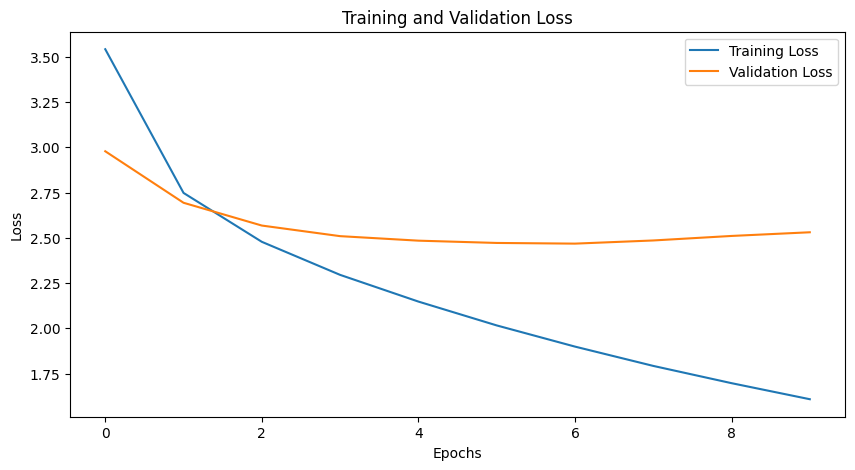

In [35]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# **Showing 3 photos of the test data with the predicted caption**

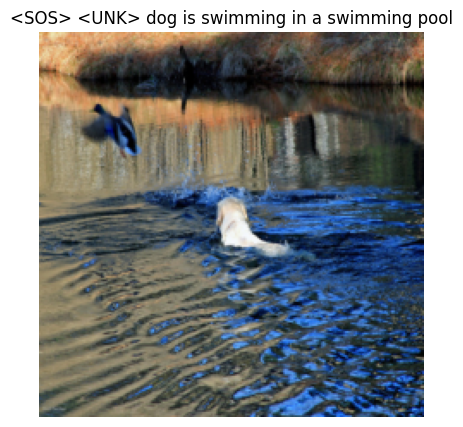

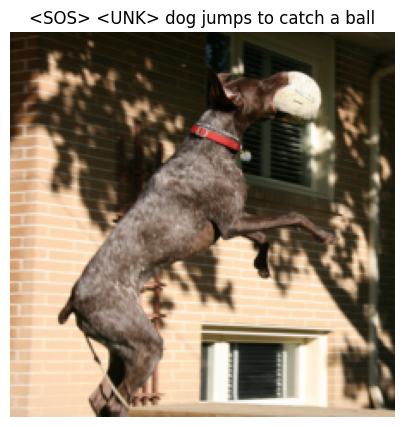

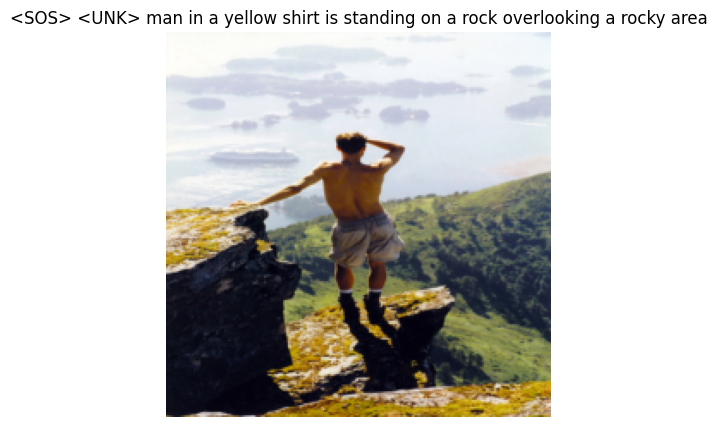

In [37]:
# Function to predict captions for a given image
def predict_caption(model, image, vocab, max_length=20):
    model.eval()
    caption = []
    with torch.no_grad():
        for i in range(max_length):
            output = model(image, torch.tensor([vocab['<SOS>']] + caption).unsqueeze(0))
            _, predicted = output.max(2)
            next_word = predicted[:, -1].item()
            if next_word == vocab['<EOS>']:
                break
            caption.append(next_word)
    return ' '.join([list(vocab.keys())[list(vocab.values()).index(idx)] for idx in caption])

# Load test images and their corresponding captions
test_images, _ = next(iter(test_loader))

# Display and predict captions for 3 test images
for i in range(3):
    r = random.randint(0,len(test_images)-1)
    plt.figure(figsize=(5, 5))
    image = test_images[r].unsqueeze(0)
    caption = predict_caption(model, image, vocab)
    plt.imshow(transforms.ToPILImage()(test_images[r]))
    plt.title(caption)
    plt.axis('off')
    plt.show()


# **PROBLEM 2.** 
### **The previous steps were for the time when all layers of the Resnet18 network were frozen. Now we check all the above steps for the time when Resnet18 layers are not frozen.**

In [38]:
# instantiate the models

cnn = CNN(freeze=False) # *** UNFREEZED ***

EMBED_SIZE = 256
HIDDEN_SIZE = 512
LSTM_LAYERS = 2
vocab_size = len(vocab)

lstm = LSTM(EMBED_SIZE, HIDDEN_SIZE, vocab_size, LSTM_LAYERS)

model_UNF = Model(cnn, lstm)

# Loss and optimizer
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model_UNF.parameters(), lr=LEARNING_RATE)

In [40]:
# Training loop
num_epoch = 10
train_losses_UNF = []
val_losses_UNF = []

for epoch in range(num_epoch):
    train_loss = train(model_UNF, train_loader, criterion, optimizer, epoch)
    val_loss = evaluate(model_UNF, test_loader, criterion)
    print("Epoch : ", epoch + 1, "Train Loss: ", train_loss, "| Validation Loss: ", val_loss)
    train_losses_UNF.append(train_loss)
    val_losses_UNF.append(val_loss)

# Save the model
torch.save(model_UNF.state_dict(), 'image_captioning_model_UNF.pth')

Epoch :  1 Train Loss:  4.154055388077445 | Validation Loss:  4.25895627025559
Epoch :  2 Train Loss:  4.150166410231307 | Validation Loss:  4.2640208321597735
Epoch :  3 Train Loss:  4.1475467333209375 | Validation Loss:  4.269994050617746
Epoch :  4 Train Loss:  4.145130508973193 | Validation Loss:  4.276631753906431
Epoch :  5 Train Loss:  4.143194250438524 | Validation Loss:  4.282980671984405
Epoch :  6 Train Loss:  4.140821401545182 | Validation Loss:  4.28900174472643
Epoch :  7 Train Loss:  4.139126494467965 | Validation Loss:  4.295390052757716
Epoch :  8 Train Loss:  4.137944234689705 | Validation Loss:  4.295571423330797
Epoch :  9 Train Loss:  4.135933570004263 | Validation Loss:  4.303873819795993
Epoch :  10 Train Loss:  4.134626928054297 | Validation Loss:  4.301094188049377


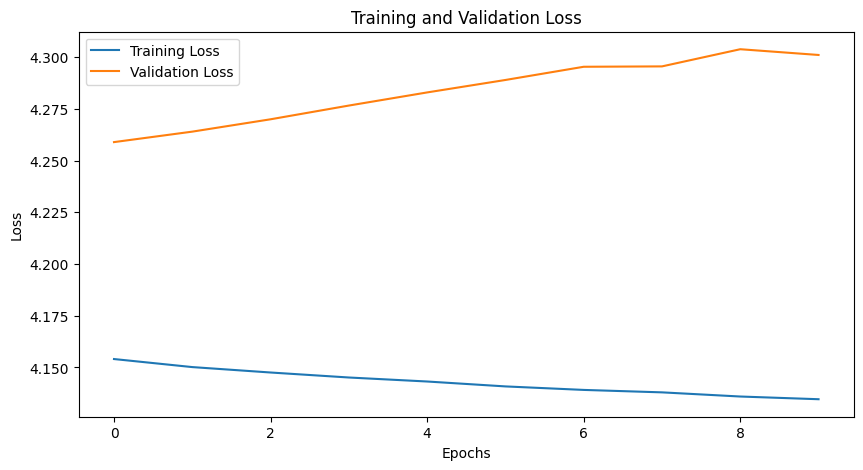

In [41]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses_UNF, label='Training Loss')
plt.plot(val_losses_UNF, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

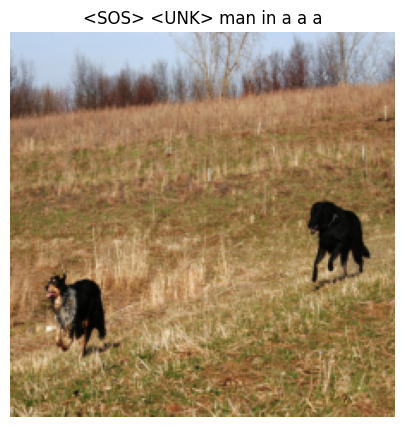

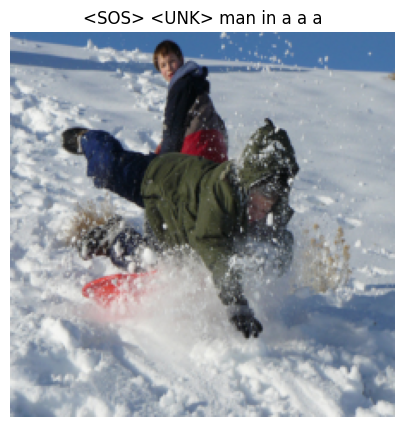

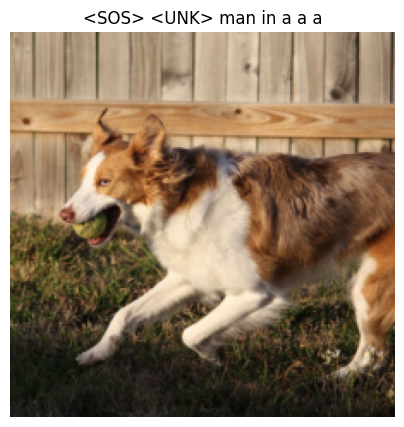

In [42]:
# Function to predict captions for a given image
def predict_caption(modelmodel_UNF, image, vocab, max_length=20):
    modelmodel_UNF.eval()
    caption = []
    with torch.no_grad():
        for i in range(max_length):
            output = model_UNF(image, torch.tensor([vocab['<SOS>']] + caption).unsqueeze(0))
            _, predicted = output.max(2)
            next_word = predicted[:, -1].item()
            if next_word == vocab['<EOS>']:
                break
            caption.append(next_word)
    return ' '.join([list(vocab.keys())[list(vocab.values()).index(idx)] for idx in caption])

# Load test images and their corresponding captions
test_images, _ = next(iter(test_loader))

# Display and predict captions for 3 test images
for i in range(3):
    r = random.randint(0,len(test_images)-1)
    plt.figure(figsize=(5, 5))
    image = test_images[r].unsqueeze(0)
    caption = predict_caption(model_UNF, image, vocab)
    plt.imshow(transforms.ToPILImage()(test_images[r]))
    plt.title(caption)
    plt.axis('off')
    plt.show()


# **Conclusion**
* As we can see, by unfreezing the layers of the Resnet18 network, our training error decreases with a very small slope in each epoch, and what is worse is that our test error increases.

* Also, in the photos shown, we can see that the predicted captions are very incomprehensible and irrelevant to the photos.

* As a result, **it is better to freeze Resnet18 network layers** to get better answers from the network.